# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.model_selection import KFold, GroupKFold,StratifiedKFold
import matplotlib.pyplot as plt
from sklearn.metrics import log_loss
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale
from sklearn.calibration import CalibrationDisplay
from itertools import combinations
from itertools import permutations
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
import optuna
from xgboost import XGBRegressor
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.metrics import log_loss
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
import joblib
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.metrics import log_loss
sns.set(style="ticks")

# Feature engeneering/selection

In [3]:
FEATS = ["total_children", "num_children_at_home", "avg_cars_at home(approx).1",
         "store_sqft", "coffee_bar", "video_store", 'florist',"prepared_food"]
INIT_FEATS =["total_children", "num_children_at_home", "avg_cars_at home(approx).1",'unit_sales(in millions)','store_sales(in millions)','units_per_case',
         "store_sqft", "coffee_bar", "video_store", 'florist',"prepared_food",'average_children','average_units','average_sales','gross_weight']

CAT_FEATS = FEATS.copy()
avg_df = pd.DataFrame(index = train.store_sqft.unique())
avg_df['store_sqft'] = avg_df.index

avg_df_test = pd.DataFrame(index = test.store_sqft.unique())
avg_df_test['store_sqft'] = avg_df_test.index

avg_df_hold = pd.DataFrame(index = hold.store_sqft.unique())
avg_df_hold['store_sqft'] = avg_df_hold.index


avg_df_original = pd.DataFrame(index = original.store_sqft.unique())
avg_df_original['store_sqft'] = avg_df_original.index

concat_train_hold_test = pd.concat([train,hold,test],ignore_index=True)
for feature in INIT_FEATS:
    if feature in ['units_per_case','store_sales(in millions)','total_children']:
        avg_df[f'avg_{feature}'] = concat_train_hold_test.groupby('store_sqft')[feature].mean()
        avg_df_test[f'avg_{feature}'] = concat_train_hold_test.groupby('store_sqft')[feature].mean()
        avg_df_hold[f'avg_{feature}'] = concat_train_hold_test.groupby('store_sqft')[feature].mean()
        avg_df_original[f'avg_{feature}'] = concat_train_hold_test.groupby('store_sqft')[feature].mean()
        
        CAT_FEATS.append(f'avg_{feature}')

train = pd.merge(train, avg_df, on='store_sqft', how='left')
hold = pd.merge(hold, avg_df_hold, on='store_sqft', how='left')
test = pd.merge(test, avg_df_test, on='store_sqft', how='left')
original = pd.merge(original, avg_df_original, on='store_sqft', how='left')
avg_df.head()

,store_sqft,avg_total_children,avg_store_sales(in millions),avg_units_per_case
21215.0,21215.0,2.376341,6.429552,18.966716
27694.0,27694.0,2.365320,6.491849,19.027253
30268.0,30268.0,2.648062,6.498345,18.915053
23593.0,23593.0,2.676023,6.478760,18.942552
23598.0,23598.0,2.372495,6.536925,19.009008


In [4]:
FEATS

['total_children',
 'num_children_at_home',
 'avg_cars_at home(approx).1',
 'store_sqft',
 'coffee_bar',
 'video_store',
 'florist',
 'prepared_food']

In [5]:
CAT_FEATS

['total_children',
 'num_children_at_home',
 'avg_cars_at home(approx).1',
 'store_sqft',
 'coffee_bar',
 'video_store',
 'florist',
 'prepared_food',
 'avg_total_children',
 'avg_store_sales(in millions)',
 'avg_units_per_case']

In [6]:
train[FEATS] = train[FEATS].round(2)
original[FEATS] = original[FEATS].round(2)

In [7]:
train.head()

,key_0,id,store_sales(in millions),unit_sales(in millions),total_children,num_children_at_home,avg_cars_at home(approx).1,gross_weight,recyclable_package,low_fat,...,store_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist,cost,avg_total_children,avg_store_sales(in millions),avg_units_per_case
0,141056,0,5.48,4.0,4.0,1.0,2.0,10.1,1.0,0.0,...,21215.0,1.0,0.0,0.0,0.0,0.0,69.63,2.376341,6.429552,18.966716
1,39904,1,6.76,2.0,1.0,0.0,2.0,17.0,0.0,0.0,...,27694.0,1.0,1.0,1.0,1.0,1.0,66.27,2.365320,6.491849,19.027253
2,148590,2,4.40,2.0,5.0,0.0,3.0,17.9,1.0,0.0,...,21215.0,1.0,0.0,0.0,0.0,0.0,138.53,2.376341,6.429552,18.966716
3,10069,3,2.70,3.0,4.0,0.0,1.0,14.0,1.0,1.0,...,30268.0,0.0,0.0,0.0,0.0,0.0,93.07,2.648062,6.498345,18.915053
4,260930,4,8.85,3.0,2.0,2.0,2.0,17.9,1.0,0.0,...,23593.0,0.0,0.0,0.0,0.0,0.0,55.22,2.676023,6.478760,18.942552


In [8]:
num_bins =5
train['bins'] = pd.cut(train['cost'], bins=num_bins).astype('category')
bins = train['bins'].unique()
bin_map = {}
for i,bin in enumerate(bins):
    bin_map[bin] = i
    
train['bins'] = train['bins'].map(bin_map)

# Train

In [9]:
ALL_USERS = train.id.unique()
gkf = GroupKFold(n_splits=5)
oof = pd.DataFrame(index=ALL_USERS)

#hyperparams
cat_params = {
    'iterations': 10000,
    'learning_rate': 0.07,
    'depth': 11,
    'l2_leaf_reg':8 ,
    'random_strength':0.5,
    'loss_function': 'RMSE',
    'eval_metric': 'RMSE',
    'task_type': 'GPU',
    'border_count': 128,
    'verbose': 1000,
    'early_stopping_rounds': 100,
    'use_best_model': True ,
    'random_state': 42,
    
}

xgb_params = {
    'objective': 'reg:squarederror',
    'tree_method': 'gpu_hist',
    'eval_metric': 'rmse',
    'seed': 42,
    'n_estimators': 1000,
    'learning_rate': 0.14774138317002128,
    'early_stopping_rounds': 1000,
    'max_depth': 11,
    'subsample': 0.90,
    'colsample_bytree': 0.90,

    'alpha': 4,
    'lambda': 5
}

targets = np.log(train.cost+1)
n_splits = 5
kf = KFold(n_splits=5, shuffle=True, random_state=100)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=100)
num_trees_cat = []
num_trees_xgb = []

for i, (train_index, test_index) in enumerate(skf.split(X=train, y=train['bins'], groups=train.index)):
    print(f'\nFold {i+1}:')

    train_x = train.iloc[train_index]
    train_x = pd.concat([train_x,original])
    train_gems = train_x.index.values
    train_y = targets.loc[train_gems]

    valid_x = train.iloc[test_index]
    valid_gems = valid_x.index.values
    valid_y = targets.loc[valid_gems]
    
    model_dict = {
            'cat': [CatBoostRegressor(**cat_params),{"eval_set":[(valid_x[CAT_FEATS].astype('float32'), valid_y)],'plot':False},CAT_FEATS],
            'xgb': [XGBRegressor(**xgb_params),{"eval_set":[(valid_x[FEATS].astype('float32'), valid_y)],"verbose":0},FEATS],
         }
    
    all_models = model_dict.keys()
    for model in all_models:
        clf = model_dict[model][0]
        clf.fit(train_x[model_dict[model][2]].astype('float32'), train_y, **model_dict[model][1])
        
        oof.loc[valid_gems, f'{model}_prediction'] = np.exp(clf.predict(valid_x[model_dict[model][2]].astype('float32')))-1
        print(f'model {model} trained')
        if model == 'cat':
            num_trees_cat.append(clf.get_best_iteration())
        if model == 'xgb':
            num_trees_xgb.append(clf.best_ntree_limit)



Fold 1:
0:	learn: 0.3154794	test: 0.3144863	best: 0.3144863 (0)	total: 20.1ms	remaining: 3m 20s
1000:	learn: 0.2993409	test: 0.2933015	best: 0.2932983 (901)	total: 15.6s	remaining: 2m 19s
bestTest = 0.2932982731
bestIteration = 901
Shrink model to first 902 iterations.
model cat trained
model xgb trained

Fold 2:
0:	learn: 0.3153398	test: 0.3153624	best: 0.3153624 (0)	total: 17.2ms	remaining: 2m 51s
1000:	learn: 0.2994302	test: 0.2930448	best: 0.2930448 (1000)	total: 15.8s	remaining: 2m 22s
bestTest = 0.2930418034
bestIteration = 1126
Shrink model to first 1127 iterations.
model cat trained
model xgb trained

Fold 3:
0:	learn: 0.3152993	test: 0.3155355	best: 0.3155355 (0)	total: 17.1ms	remaining: 2m 50s
bestTest = 0.2950967624
bestIteration = 882
Shrink model to first 883 iterations.
model cat trained
model xgb trained

Fold 4:
0:	learn: 0.3153211	test: 0.3154367	best: 0.3154367 (0)	total: 17.7ms	remaining: 2m 56s
bestTest = 0.2943040242
bestIteration = 722
Shrink model to first 723 i

# Stratified CV

In [10]:
from sklearn.metrics import mean_squared_log_error
rmses = {}
targets = train.cost
for model in all_models:
    rmses[f"{model}_prediction"] = mean_squared_log_error(targets,oof[f'{model}_prediction'], squared=False)
    print(f'{model} = {rmses[f"{model}_prediction"]}')
    
oof['prediction'] = 0
rmse_inv_sum = 0
for model in all_models:
    if model in ['xgb','lgb','cat']:
        oof['prediction'] = oof['prediction'] + oof[f'{model}_prediction'] * (1/rmses[f'{model}_prediction'])
        rmse_inv_sum += 1/rmses[f'{model}_prediction']
    
#print('xgb = 0.2930786590554832')
oof['prediction'] = oof['prediction'] / rmse_inv_sum
print(f'ensemble = {mean_squared_log_error(targets,oof[f"prediction"], squared=False)}')

cat = 0.2939366082095198
xgb = 0.2940405102871711
ensemble = 0.2939274709439068


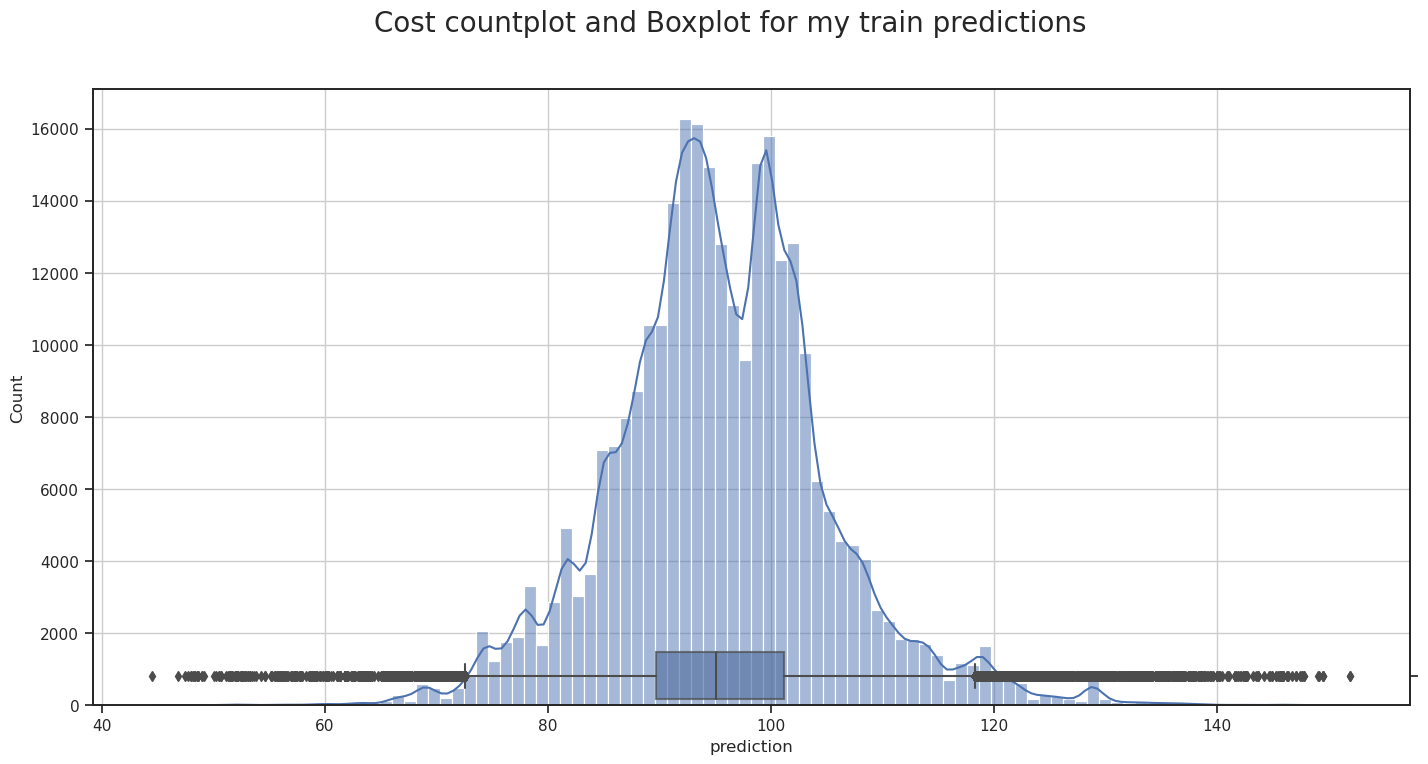

In [11]:
fig, ax = plt.subplots(figsize=(17,8)) 
sns.histplot(data=oof, x="prediction",bins = 100, ax=ax, kde = True)
ax2 = ax.twinx()
sns.boxplot(data=oof, x="prediction", ax=ax2,boxprops=dict(alpha=.7))
ax2.set(ylim=(-.5, 10))
plt.suptitle('Cost countplot and Boxplot for my train predictions', fontsize=20)
ax.grid(True)
plt.show()

# Hold

In [12]:
print(f"CAT :{num_trees_cat}; mean : {np.array(num_trees_cat).mean()}")
print(f"XGB :{num_trees_xgb}; mean : {np.array(num_trees_xgb).mean()}")
print()
hold_num_trees_cat = int(np.array(num_trees_cat).mean()*1.25)
hold_num_trees_xgb = int(np.array(num_trees_xgb).mean()*1.25)
#cat model
cat_params2 = cat_params.copy()
cat_params2.pop('iterations')
cat_params2.pop('early_stopping_rounds')
cat_params2.pop('use_best_model')
new_params = {
    'iterations': hold_num_trees_cat,
}

hold_cat = CatBoostRegressor(**cat_params2,**new_params)
hold_cat.fit(train[CAT_FEATS].astype('float32'), np.log(train.cost+1),plot=False)


#xgb model
xgb_params2 = xgb_params.copy()
xgb_params2.pop('early_stopping_rounds')
xgb_params2['n_estimators'] = hold_num_trees_xgb

hold_xgb = XGBRegressor(**xgb_params2)
hold_xgb.fit(train[FEATS].astype('float32'), np.log(train.cost+1))

#hold oof
hold_pred = pd.DataFrame(index = hold.id)

hold_pred['cat_predictions'] = np.exp(hold_cat.predict(hold[CAT_FEATS].astype('float32')))-1
hold_pred['xgb_predictions'] = np.exp(hold_xgb.predict(hold[FEATS].astype('float32')))-1
hold_pred['predictions'] = (hold_pred['xgb_predictions'] + hold_pred['cat_predictions']) /2

#rmsles
print(f"\nhold cat prediction: {mean_squared_log_error(hold.cost,hold_pred['cat_predictions'], squared=False)}")
print(f"hold xgb prediction: {mean_squared_log_error(hold.cost,hold_pred['xgb_predictions'], squared=False)}")
print(f"\nhold ensemble prediction: {mean_squared_log_error(hold.cost,hold_pred['predictions'], squared=False)}")

CAT :[901, 1126, 882, 722, 839]; mean : 894.0
XGB :[970, 984, 958, 963, 997]; mean : 974.4

0:	learn: 0.3148942	total: 16.9ms	remaining: 18.9s
1000:	learn: 0.2912932	total: 15.4s	remaining: 1.78s
1116:	learn: 0.2912804	total: 17.1s	remaining: 0us

hold cat prediction: 0.29355145750541917
hold xgb prediction: 0.2935512255175029

hold ensemble prediction: 0.2934855789516012


In [13]:
hold_pred.head()

,cat_predictions,xgb_predictions,predictions
id,,,
191948,112.671837,112.884872,112.778355
143368,91.400238,91.996666,91.698452
16664,99.708412,99.682533,99.695473
49607,99.679850,99.669617,99.674733
228005,108.390238,108.186714,108.288476


# Inference

In [14]:
new_params = {
    'iterations': int(hold_num_trees_cat*1.25),
}

last_train = pd.concat([train,hold,original], ignore_index=True)

test_cat = CatBoostRegressor(**cat_params2,**new_params)

xgb_params3 = xgb_params2.copy()
xgb_params3['n_estimators'] = int(xgb_params3['n_estimators']*1.25)
test_xgb = XGBRegressor(**xgb_params3)

test_xgb.fit(last_train[FEATS].astype('float32'), np.log(last_train.cost+1))
test_cat.fit(last_train[CAT_FEATS].astype('float32'), np.log(last_train.cost+1),plot=False)

submission = pd.DataFrame(index = test.id)
submission['id'] = submission.index

submission['cost_xgb'] = np.exp(test_xgb.predict(test[FEATS].astype('float32')))-1
submission['cost_cat'] = np.exp(test_cat.predict(test[CAT_FEATS].astype('float32')))-1
submission['cost'] = (submission['cost_xgb'] + submission['cost_cat']) / 2

0:	learn: 0.3151775	total: 16.1ms	remaining: 22.4s
1000:	learn: 0.2922732	total: 16.8s	remaining: 6.64s
1395:	learn: 0.2922435	total: 22.8s	remaining: 0us


In [15]:
submission.head()

,id,cost_xgb,cost_cat,cost
id,,,,
360336,360336,90.134430,90.216530,90.175480
360337,360337,94.201973,94.258625,94.230299
360338,360338,94.396187,94.388595,94.392391
360339,360339,99.006927,99.129868,99.068398
360340,360340,78.339905,78.380880,78.360392


In [16]:
submission[['id','cost']].to_csv('submission.csv', index= False)